<a href="https://colab.research.google.com/github/imendezguerra/wandb_tutorial/blob/main/wandb_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weights and biases (W&B) tutorial
Resources:
- [W&B main page](https://wandb.ai)
- [W&B documentation](https://docs.wandb.ai)
- [W&B courses](https://https://wandb.ai/site/courses/)

Weights and biases (W&B) is a popular MLOps platform used to track and manage machine-learning experiments. It aims to bring order, reproducibility, and efficiency to the chaotic world of ML experimentation.

To do this W&B provides (among other specialised features):
- Experiment tracking
- Model and dataset versioning
- Metric and data interactive visualisations
- Hyperparameter sweeps
- Collaborative environment
- Integrations with common AI-tools (PyTorch, TensorFlow, JAX, Keras, HuggingFace, etc.)

Together, these capabilities make ML research faster, more reliable, reproducible, scalable, and collaborative.

In this tutorial we will cover the basic functions going through:
- W&B registration and installation
- logging, downloading, and using artifacts
- logging models, metadata, and metrics
- performing hyperparameter sweeps
- visualising metrics (W&B interactive dashboard)
- creating a report (W&B)

The notebook is structured as follows:
1. [W&B registration](#1-wb-registration)
2. [W&B installation](#2-wb-installation)
3. [Dataset preparation](#3-prepare-dataset)
4. [Model training](#4-model-training)
5. [Model optimisation](#5-model-optimisation)
6. [Model evaluation](#6-model-evaluation)

## 1. W&B registration
W&B offers a free forever plan for academic research including:
- coordinating projects remotely
- unlimited tracking hours, teams, projects
- 100GB free cloud storage

Sign-up in [wandb.ai](https://wandb.ai) using your academic email to unlock the benefits.

## 2. W&B installation
First, replicate the environment using:

In [ ]:
# !conda env create -f environment.yml # Recreate the environment to run this notebook

To install the `wandb` package run the following commands:

In [ ]:
# !pip install wandb

To authenticate your machine with W&B, generate an API key from your user profile at wandb.ai/authorize. Copy the API key and store it securely. Then run:

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: im4417 (icl_img) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Define the project name in wandb and initialise seeds for reproducibility

In [ ]:
WANDB_TEAM = 'icl_img'
WANDB_USER = 'im4417'
PROJECT = 'wandb_tutorial'

import os
from pathlib import Path
from loguru import logger
from typing import Optional 
import torch
import torch.nn.functional as F
from src.dataset import generate_dataset, get_dataloaders_from_artifact
from src.model import MLP, get_device


%load_ext autoreload
%autoreload 2

: 

## 3. Prepare dataset 
Here we will :
1. generate a synthetic dataset for further use
2. split it into train/val/test,
3. save it to disk as `.npz`,
4. log it as a W&B Artifact of type `dataset`,

To do this, the notebook uses functions from `src\wandb_tutorial`. In this case the dataset comprises:
- 2D datapoints  
- with moderate overlap  
- including 3 clusters 

The important part of this section is to showcase how to log artifacts in wandb for data versioning. To do so, take a look at the function below. Note that multiple datatypes (files) can be stored under the same artifact.

In [ ]:
def log_artifact_wandb(
        files: list[str],
        files_path: Path,
        description: str,
        artifact_type: str,
        run: Optional[wandb.Run]=None
    ):
    """Log dataset into wandb."""
    # Initialise run to upload data if run not provided
    if not run:
        run = wandb.init(project=PROJECT)
    # Define artifact (equivalent to a folder)
    artifact = wandb.Artifact(
        name=files_path.name,
        type=artifact_type,
        description=description,
    )
    # Add files to remote artifact
    for file in files:
        artifact.add_file(files_path / file) 

    # Log artifact (equivalent to commit)
    run.log_artifact(artifact)
    # Finish the run
    run.finish()
    logger.success("Artifact successfully uploaded.")


2025-11-25 11:49:19.719 | INFO     | src.dataset:generate_dataset:34 - Blobs generated
2025-11-25 11:49:19.726 | INFO     | src.dataset:generate_dataset:49 - Data separated into:
2025-11-25 11:49:19.726 | INFO     | src.dataset:generate_dataset:55 - Train split
2025-11-25 11:49:19.727 | INFO     | src.dataset:generate_dataset:56 - ---------------
2025-11-25 11:49:19.728 | INFO     | src.dataset:generate_dataset:57 - X: (3240, 2)
2025-11-25 11:49:19.729 | INFO     | src.dataset:generate_dataset:58 - y: (3240,)
2025-11-25 11:49:19.730 | INFO     | src.dataset:generate_dataset:55 - Validation split
2025-11-25 11:49:19.730 | INFO     | src.dataset:generate_dataset:56 - ---------------
2025-11-25 11:49:19.731 | INFO     | src.dataset:generate_dataset:57 - X: (360, 2)
2025-11-25 11:49:19.732 | INFO     | src.dataset:generate_dataset:58 - y: (360,)
2025-11-25 11:49:19.733 | INFO     | src.dataset:generate_dataset:55 - Test split
2025-11-25 11:49:19.734 | INFO     | src.dataset:generate_datase

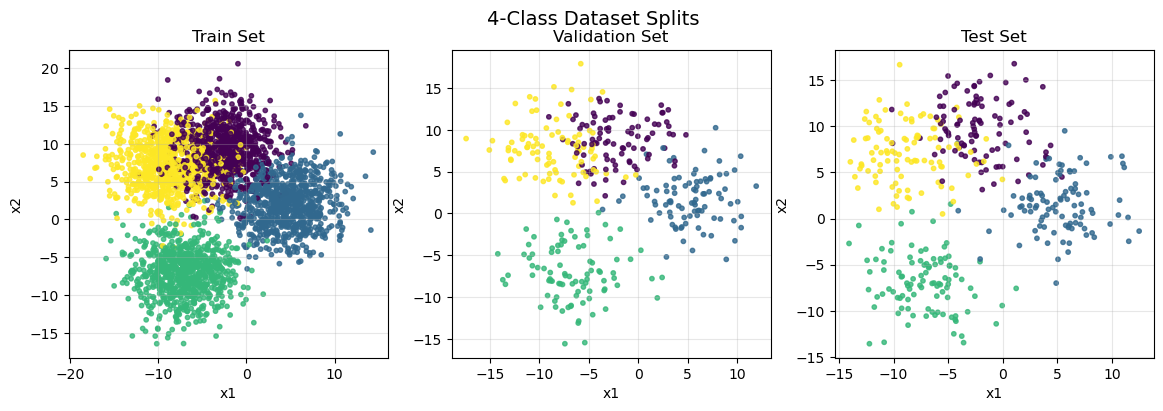

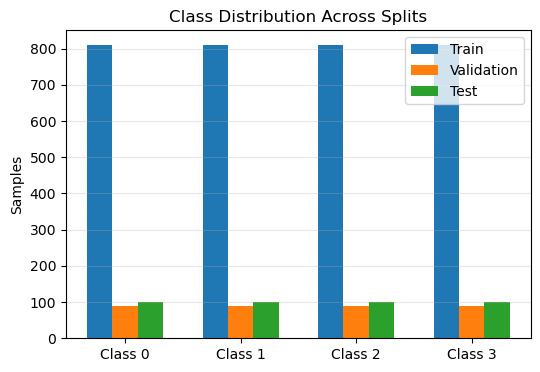

In [ ]:
# Define data config and output path
output_path = Path('data', 'blob_dataset')
config = {
    'seed': 42,
    'n_samples': 1000,
    'n_features': 2,
    'n_classes': 4,
    'cluster_std': 3,
    'val_size': 0.1,
    'test_size': 0.1,
}

# Generate synthetic dataset and store it locally
generate_dataset(config, output_path)

In [ ]:
# Log artifacts into wandb
log_artifact_wandb(
    files = [
        'data_train.npz', 'data_val.npz', 'data_test.npz',
        'data_split.png', 'data_class_split.png', 'config.yml'
    ],
    files_path = output_path,
    artifact_type = 'dataset',
    description = 'Blob dataset split into train/val/test.'  
)

2025-11-25 11:49:32.663 | SUCCESS  | __main__:log_artifact_wandb:26 - Artifact successfully uploaded.


## 4. Model training
In this section we will:
1. Use the dataset generated before to
2. Train an MLP to predict the corresponding classes
3. Log model hyperparameters (config) along with performance metrics during training 
4. Save final model checkpoint as another artifact

Take a look at the function below to see how to download artifacts stored in wandb:

In [ ]:

def download_artifact_wandb(
    path_to_artifact: str,
    artifact_type: str,
    artifact_version: Optional[str]=None,
    run: Optional[wandb.Run] = None
) -> wandb.Artifact:
    """Download artifact from wandb."""
    # Initialise run if not provided
    if not run:
        run = wandb.init()
        init_run = True
    else:
        init_run = False
    # Specify the version of the dataset, defaults to latest
    artifact_version = 'latest' if artifact_version is None else artifact_version
    # Make full path
    artifact_dir = f'{WANDB_TEAM}/{PROJECT}/{path_to_artifact}:{artifact_version}'
    logger.info(artifact_dir)
    # Ensure artifact exists
    if artifact_exists(artifact_dir):
        # Point to artifact and retrieve path (download)
        artifact = run.use_artifact(artifact_dir, type=artifact_type)
        artifact_dir = artifact.download()
        logger.success(f'Artifact {path_to_artifact} successfully downloaded.')
    else:
        logger.error(f'Artifact {path_to_artifact} does not exist.')
    # Finish run if initialised in function
    if init_run:
        run.finish()
    return artifact_dir

def artifact_exists(artifact_ref: str) -> bool:
    """Check if an artifact exists in wandb."""
    api = wandb.Api()
    try:
        _ = api.artifact(artifact_ref)
        return True
    except wandb.errors.CommError:
        # No run active
        return False
    except wandb.errors.ArtifactNotFoundError:
        # No matching artifact
        return False  


The following code shows the general syntax to log metrics in wandb during model training/validation/testing. For real-time visulalisation, implement it in the epoch loop.

In [ ]:
def train_one_epoch(model, loader, optimizer, epoch, run=None, device="cpu"):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for step, (X_batch, y_batch) in enumerate(loader):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        loss = F.cross_entropy(logits, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += X_batch.size(0)

        if run is not None and step % 20 == 0:
            run.log({"train/batch_loss": loss.item(), "train/step": epoch * len(loader) + step})

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc

@torch.no_grad()
def evaluate(model, loader, epoch=None, run=None, prefix="val", device="cpu"):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    for X_batch, y_batch in loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)
        loss = F.cross_entropy(logits, y_batch)

        total_loss += loss.item() * X_batch.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += X_batch.size(0)

    avg_loss = total_loss / total
    acc = correct / total

    if run is not None and epoch is not None:
        run.log({f"{prefix}/loss": avg_loss, f"{prefix}/acc": acc, "epoch": epoch})

    return avg_loss, acc


In [ ]:
def run_training(config=None):
    if config is None:
        config = {
            "epochs": 20,
            "batch_size": 64,
            "lr": 1e-3,
            "input_dim": 2,
            "hidden_dim": 64,
            "output_dim": 4,
            "dropout": 0.1,
            "dataset_artifact": "blob_dataset",
            "device": "cuda",
            "dtype": "float32",
        }

    # Check dtype and device
    config["device"] = get_device()

    run = wandb.init(
        project=PROJECT,    # Initialise run in the project
        config=config,      # Automatically save config
        job_type="train"    # Tag for job type
    )
    
    # Retrieve artifact remote path
    artifact_dir = download_artifact_wandb(
        path_to_artifact = config['dataset_artifact'],
        artifact_type = 'dataset',
        run = run
    )
    # Load and format dataset artifact into DataLoader
    train_loader, val_loader, test_loader = get_dataloaders_from_artifact(
        artifact_dir=artifact_dir, batch_size=config['batch_size'],
        device=config["device"]
    )

    model = MLP(
        input_dim=config['input_dim'],
        hidden_dim=config['hidden_dim'],
        output_dim=config['output_dim'],
        dropout=config['dropout']
    ).to(device=config["device"])
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

    best_val_acc = 0.0
    model_name = "best_base_model.pt"
    model_path = Path("checkpoints")
    model_path.mkdir(exist_ok=True)

    for epoch in range(config['epochs']):
        # Train and validate model per epoch
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, epoch, 
            run, device=config["device"]
        )
        val_loss, val_acc = evaluate(
            model, val_loader, epoch, run, 
            prefix="val", device=config["device"]
        )

        logger.info(
            f"Epoch {epoch}: "
            f"train_loss={train_loss:.4f}, train_acc={train_acc:.3f}, "
            f"val_loss={val_loss:.4f}, val_acc={val_acc:.3f}"
        )

        # Track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), model_path/model_name)
            run.log({"best_val_acc": best_val_acc})

    # Log the best model as an artifact
    log_artifact_wandb(
        files = [model_name],
        files_path = model_path,
        artifact_type = 'model',
        description = 'Best baseline model according to validation accuracy',
        run=run
    )

    run.finish()


In [ ]:
# Run one baseline experiment
run_training()

2025-11-25 11:53:01.283 | INFO     | __main__:download_artifact_wandb:18 - icl_img/wandb_tutorial/blob_dataset:latest
wandb:   6 of 6 files downloaded.  
2025-11-25 11:53:04.155 | SUCCESS  | __main__:download_artifact_wandb:24 - Artifact blob_dataset successfully downloaded.


RuntimeError: Numpy is not available

## 5. Model optimisation

Now we will use **W&B Sweeps** to explore hyperparameters:
- learning rate (`lr`)
- hidden layer size (`hidden_dim`)
- dropout

Workflow:

1. Define a **sweep configuration** (search space + objective).
2. Define a training function `sweep_train()` that:
   - reads hyperparameters from `wandb.config`
   - trains & logs metrics

In the W&B UI, you’ll see:
- individual runs
- parallel coordinate plots
- best hyperparameter configurations


In [ ]:
sweep_config = {
    "method": "random",  # or "grid"
    "metric": {
        "name": "val/acc",
        "goal": "maximize"
    },
    "parameters": {
        "epochs": {"value": 20},
        "batch_size": {"values": [32, 64, 128]},
        "lr": {"values": [1e-2, 3e-3, 1e-3, 3e-4]},
        "hidden_dim": {"values": [32, 64, 128]},
        "dropout": {"values": [0.0, 0.1, 0.3]},
        "dataset_artifact": {"value": "blob_dataset"},
        "device": "cpu"
    }
}


In [ ]:
def sweep_train():

    run = wandb.init(
        project=PROJECT,    # Initialise run in the project
        config=config,      # Automatically save config
        job_type="train"    # Tag for job type
    )
    
    # Retrieve artifact remote path
    artifact_dir = download_artifact_wandb(
        path_to_artifact = config['dataset_artifact'],
        artifact_type = 'dataset',
        run = run
    )
    # Load and format dataset artifact into DataLoader
    train_loader, val_loader, test_loader = get_dataloaders_from_artifact(
        artifact_dir=artifact_dir, batch_size=config['batch_size'],
        device=config["device"]
    )

    model = MLP(
        input_dim=config['input_dim'],
        hidden_dim=config['hidden_dim'],
        output_dim=config['output_dim'],
        dropout=config['dropout']
    ).to(device=config["device"])
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])


    for epoch in range(config['epochs']):
        # Train and validate model per epoch
        train_loss, train_acc = train_one_epoch(
            model, train_loader, optimizer, epoch, 
            run, device=config["device"]
        )
        val_loss, val_acc = evaluate(
            model, val_loader, epoch, run, 
            prefix="val", device=config["device"]
        )
        run.log({"val/loss": val_loss, "val/acc": val_acc})
    
    run.finish()


## 6. Model evaluation
In wandb interactive dashboard